In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from datetime import datetime 
from sklearn.metrics import roc_auc_score as auc 

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [22]:
df = pd.read_csv('transformed_data.csv')
print df.head()
#names=
raw = pd.read_csv('uniform_currency_data.csv')
print len(raw)

   55  12  554629.0    8271.48   69  1  1.1  0  1443650865.0  3  154469  \
0  55  12  548234.0   1262.394  112  1    1  0  1.443651e+09  3  273959   
1  55  12  547046.0   7302.260   69  1    1  0  1.443651e+09  3  260168   
2  55   5  477291.0  10311.400  112  1    1  0  1.443651e+09  3  137032   
3  55  12  557910.0   8372.100   69  1    1  0  1.443651e+09  3  106983   
4  55  12  549949.0   5108.400   69  1    1  0  1.443651e+09  3  252274   

   111262  219189  0.1  
0   39640  258889    0  
1   64811  180723    0  
2  163136   13838    0  
3  114270   68484    0  
4   61392  215813    0  
236698


## Split data by 50-50

In [23]:
TEST_RATIO = 0.2
df.sort_values('1443650865.0', inplace = True)
TRA_INDEX = int((1-TEST_RATIO) * df.shape[0])
train_x = df.iloc[:TRA_INDEX, 0:-4].values
train_y = df.iloc[:TRA_INDEX, -1].values

test_x = df.iloc[TRA_INDEX:, 0:-4].values
test_y = df.iloc[TRA_INDEX:, -1].values
print train_x[1,:]

[1.80000000e+01 1.00000000e+01 4.92181000e+05 5.53135000e+03
 2.60000000e+01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.43570164e+09 0.00000000e+00]


In [24]:
from imblearn.over_sampling import SMOTE

def sm_sample(x_train,y_train):
    sm = SMOTE()
    # x_array = np.array(x)
    # y_array = np.array(y)
    usx = x_train.astype('float64')
    usy = y_train.astype('float64')

    X_res, y_res = sm.fit_sample(usx, usy)
    #print(format(Counter(y_train)))
    #print('Resampled dataset shape {}'.format(Counter(y_res)))
    return X_res, y_res
    #rf_train(X_res,y_res,x_test,y_test)

In [ ]:
#train_x, train_y = sm_sample(train_x,train_y)

## Pre-processing - z scores

In [25]:
cols_mean = []
cols_std = []
for c in range(train_x.shape[1]):
    #
    cols_mean.append(train_x[:,c].mean())
    cols_std.append(train_x[:,c].std())
    train_x[:, c] = (train_x[:, c] - cols_mean[-1]) / cols_std[-1]
    if c==7:
        print train_x[:,c]
    
    test_x[:, c] =  (test_x[:, c] - cols_mean[-1]) / cols_std[-1]

[ 0.47551138  0.47551138  0.47551138 ...  0.47551138 -2.03882593
  0.47551138]


## import RBM

In [26]:
from rbm import RBM

In [27]:
len(train_x)

189356

## Initialize model object with momentum

In [28]:
model = RBM(train_x.shape[1], 10, visible_unit_type='gauss', main_dir='/home/ava/Dropbox/CyberData/ass1/rbm/model', model_name='rbm_model.ckpt',
                 gibbs_sampling_steps=4, learning_rate=0.001, momentum = 0.95, batch_size=500, num_epochs=10, verbose=1)


## Train it and plot training reconstruction loss v.s. iteractions

Validation cost at step 0: 1.072619
Validation cost at step 1: 0.9677266
Validation cost at step 2: 0.70099676
Validation cost at step 3: 0.6648756
Validation cost at step 4: 0.6851689
Validation cost at step 5: 0.66244256
Validation cost at step 6: 0.6398106
Validation cost at step 7: 0.65740716
Validation cost at step 8: 0.63242644
Validation cost at step 9: 0.65836084


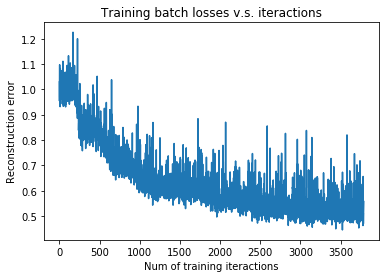

In [29]:
model.fit(train_x, validation_set=test_x)


## Make predictions on val - Free Energy

In [30]:
test_cost = model.getFreeEnergy(test_x).reshape(-1)
print test_cost, len(test_cost),len(test_y)

[-6.9757543 -7.177141  -6.514738  ... -6.7884216 -5.3044634 -6.7870007] 47340 47340


## AUC-ROC curve on val

In [31]:
auc(test_y, test_cost)

ValueError: Reordering is not turned on, and the x array is not increasing: [0 0 0 ... 0 0 0]

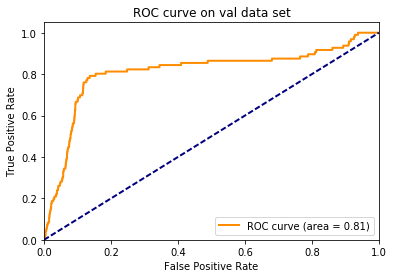

In [32]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(test_y, test_cost)

fpr_micro, tpr_micro, _ = roc_curve(test_y, test_cost)
roc_auc = auc(fpr_micro, tpr_micro)

plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on val data set')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
def rbm_train(train_x,test_x,test_y,):
    model.fit(train_x, validation_set=test_x)
    test_cost = model.getFreeEnergy(test_x).reshape(-1)
    print auc(test_y, test_cost)
    fpr, tpr, _ = roc_curve(test_y, test_cost)

    fpr_micro, tpr_micro, _ = roc_curve(test_y, test_cost)
    roc_auc = auc(fpr_micro, tpr_micro)

    plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve on val data set')
    plt.legend(loc="lower right")
    plt.show()

## Distribution for FE on val set - fraud and non-fraud

In [ ]:
from imblearn.over_sampling import SMOTE

def sm_sample(x_train,y_train,x_test,y_test):
    sm = SMOTE()
    # x_array = np.array(x)
    # y_array = np.array(y)
    usx = x_train.astype('float64')
    usy = y_train.astype('float64')

    X_res, y_res = sm.fit_sample(usx, usy)
    #print(format(Counter(y_train)))
    #print('Resampled dataset shape {}'.format(Counter(y_res)))

    #rf_train(X_res,y_res,x_test,y_test)
    


In [ ]:
sm_sample(train_x,train_y,test_x,test_y)

In [ ]:
#plt.hist(test_cost[np.where(test_y == 1)], bins = 100)
plt.title('Free energy distribution of val set')
plt.xlabel('Free energy')
plt.ylabel('Probabilties')
plt.hist(test_cost[(test_y == 0) & (test_cost < 500)], bins = 100, color='green', normed=1.0, label='Non-Fraud')
plt.hist(test_cost[(test_y == 1) & (test_cost < 500)], bins = 100, color='red', normed=1.0, label = 'Fraud')

plt.legend(loc="upper right")
plt.show()

In [ ]:
#plt.hist(test_cost[np.where(test_y == 1)], bins = 100)
plt.hist(test_cost[(test_y == 0) & (test_cost < 500)], bins = 100, color='green', normed=1)
plt.title('Free energy distribution of non-fraud cases')
plt.xlabel('Free energy')
plt.ylabel('Probabilities')
plt.show()

In [ ]:
#plt.hist(test_cost[np.where(test_y == 1)], bins = 100)
plt.hist(test_cost[(test_y == 1) & (test_cost < 500)], bins = 100, color='red', normed=1)
plt.title('Free energy distribution of fraud cases')
plt.xlabel('Free energy')
plt.ylabel('Probabilities')
plt.show()

## Finding a threshold for real time fraud detector

### Precision Recall Curve in general

In [ ]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall(lines):
    

    for precision, recall, label in lines:
        plt.plot(recall, precision, label=label)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall')
    plt.legend(loc="upper right")
    plt.show()
    
lines = []
precision, recall, threshold = precision_recall_curve(test_y, test_cost)

lines.append( (precision, recall, 'Precision Recall Curve') )
plot_precision_recall(lines)

### Finding a threshold of Free Energy on range(0, 200) that best balances Precision and Recall

In [ ]:
precisions = []
recalls = []
all_pos = sum(test_y)
for threshold in range(1, 200):
    all_predicted = sum(test_cost > threshold)
    TP = sum((test_cost > threshold) & (test_y == 1))
    
    precisions.append(TP  / all_predicted)
    recalls.append(TP / all_pos)

plt.plot( recalls, label = 'recall')
plt.axvline(100, color = 'red')

plt.title("Recall curve")
plt.xlabel("FE")
plt.ylabel("Recall")
plt.legend()
plt.show()

In [ ]:
plt.plot( precisions, label = 'precision')
plt.axvline(100, color = 'red')

plt.title("Precision curve")
plt.xlabel("FE")
plt.ylabel("Precision")
plt.legend()
plt.show()

## Take a look at the top 500 transactions for example ....

In [ ]:
value_500 = sorted(test_cost)[-500]
population_mean = np.mean(test_y)
model_mean_500 = np.mean(test_y[test_cost > value_500])
print("Perc of fraud in val data is: %0.2f%%; perc of fraud in top 500 by model is: %0.2f%%" % (population_mean*100, model_mean_500*100))